# Classifying LSST Data With BigMorpheus/Morpheus-Core

This is a protoype of the simplest setup for classifying data with BigMorpheus
and Morpheus-Core

`morpheus_core` is a pip installable package

`bit_morpheus_helper` is a local file

TODO:
1. Test out parallel classification
2. Learn more about valid inputs to butler

In [1]:
!source ~/venv/morpheus-env/bin/activate

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import simple_norm

from morpheus_core import morpheus_core
import big_morpheus_helper as bm

from lsst.daf.butler import Butler

## Get A Sample Image

This follows the example from the LSST Notebooks

In [13]:
dataId = {'visit': 192350, 'detector': 175, 'band': 'i'}

repo = 's3://butler-us-central1-dp01'
collection = '2.2i/runs/DP0.1'
butler = Butler(repo, collections=collection)
calexp = butler.get('calexp', **dataId)

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/obs_base/22.0.1-29-ge050cc6+6e21b5568a/python/lsst/obs/base/formatters/fitsExposure.py:623: UserWarning: Data ID {instrument: 'LSSTCam-imSim', detector: 174, visit: 192350} is missing (implied) value(s) for ['band', 'physical_filter']; the correctness of this Exposure's FilterLabel cannot be guaranteed. Call Registry.expandDataId before Butler.get to avoid this.
  warnings.warn(f"Data ID {self.dataId} is missing (implied) value(s) for {missing}; "


### Get the data as an array and plot

In [29]:
data = calexp.image.array

Image Shape (4000, 4072)


classifying:   0%|          | 2/967 [07:54<63:33:47, 237.13s/batch]


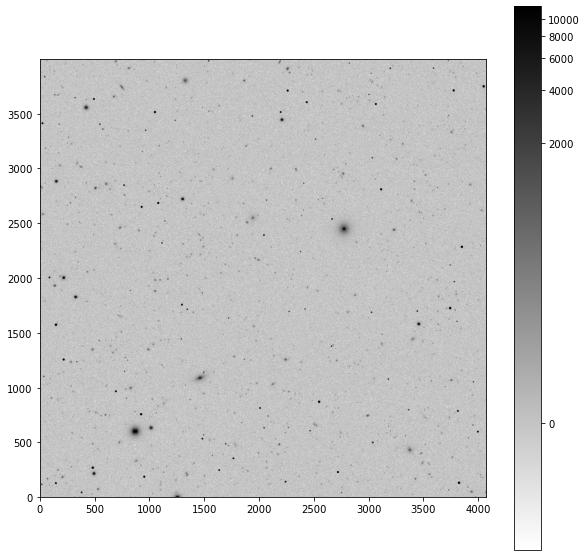

In [16]:
plt.figure(figsize=(10, 10))
plt.imshow(
    data,
    origin="lower",
    cmap="binary",
    norm=simple_norm(
        data, 
        stretch="log",
        max_percent=99.99,
        min_percent=25,
    )
)
plt.colorbar()

### Classify this image using Big Morpheus / Morpheus Core

In [ ]:
morpheus = bm.get_morpheus()

In [69]:
# The calculation for the stride that covers the whole image with the minium number of steps is the 
# greatest factor less than the window size of the dimension minus the window size
def calc_max_stride(img_dim, window_dim):
    last_step = img_dim - window_dim
    stride = max(filter(lambda i: last_step % i == 0, range(1, window_dim)))
    return stride

print("Optimal Stride: ({}, {})".format(calc_max_stride(data.shape[0], 512), calc_max_stride(data.shape[1], 512)))

Optimal Stride: (436, 445)


In [58]:
# If we want to reclassify the image we need to remove the outputs from disk
# as a safety precaution BigMorpheus will fail if they exist
if os.path.exists("n.fits"):
    os.remove("n.fits")
    os.remove("output.fits")

n_classes = 5
batch_size = 10
window_shape = (512, 512)

inputs = [
    data[..., np.newaxis],
]

classified = morpheus_core.predict(
    morpheus,
    inputs,
    n_classes,
    batch_size,
    window_shape,
    stride = (436, 445),
    aggregate_method="rank_vote",
    out_dir=".",
    #cpus=4
)

classifying: 9batch [01:27,  9.71s/batch]                    


### Make a colorized output

In [59]:
color_out = bm.colorize_output(classified[1][0])

100%|██████████| 4000/4000 [00:17<00:00, 232.02it/s]


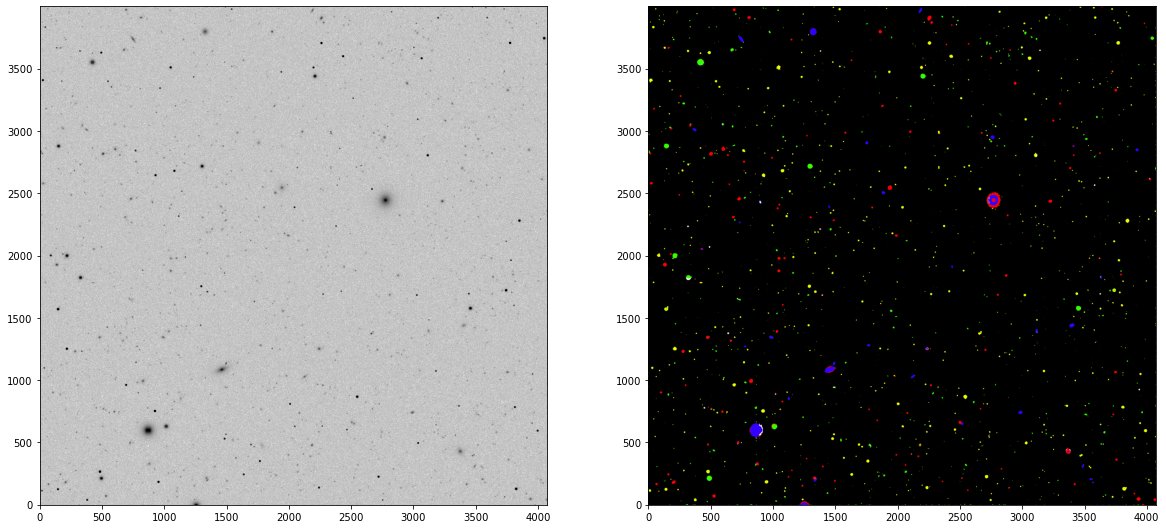

In [60]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))

ax1.imshow(
    data,
    origin="lower",
    cmap="binary",
    norm=simple_norm(
        data, 
        stretch="log",
        max_percent=99.99,
        min_percent=25,
    )
)

ax2.imshow(
    color_out,
    origin="lower"
)

plt.show()